In [4]:
# ====== CONFIG (EDIT THESE) ======
DATA_PATH      = "../clean_data/lemmatized_tokenized_data.csv"  # <-- set your .parquet path
TEXT_COL       = "tokenized_text"                       # <-- set your text column name
N_TOPICS       = 30                           # try 5/10/15 depending on your data size
N_TOP_WORDS    = 20                           # top words to show per topic
MAX_FEATURES   = 30000                        # vocab cap (bag-of-words)

# ====== IMPORTS ======
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.lda_model as lda_vis

print("Config OK.")

Config OK.


In [5]:
import ast
import json

df = pd.read_csv(
    "../clean_data/lemmatized_tokenized_data.csv"
)

# Remove index-like column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

assert TEXT_COL in df.columns, f"Column '{TEXT_COL}' not found. Available: {list(df.columns)[:12]}..."

# Normalize tokens into plain space-separated strings
def to_text(s):
    if pd.isna(s):
        return ""
    if isinstance(s, list):
        return " ".join(map(str, s))
    if isinstance(s, str):
        txt = s.strip()

        # Already space-separated tokens? (most common)
        if (" " in txt) and not txt.startswith("[") and not txt.startswith("{"):
            return txt

        # Python list string: "['word','word']"
        try:
            py_list = ast.literal_eval(txt)
            if isinstance(py_list, list):
                return " ".join(map(str, py_list))
        except Exception:
            pass

        # JSON list string: '["word","word"]'
        try:
            js = json.loads(txt)
            if isinstance(js, list):
                return " ".join(map(str, js))
        except Exception:
            pass

        return txt

    return str(s)

df[TEXT_COL] = df[TEXT_COL].apply(to_text)

display(df[[TEXT_COL]].head(5))
print("Rows:", len(df))

,tokenized_text
0,last federal reserve board issued rule organiz...
1,test door service service board examine r safe...
2,sanction chinese contract
3,lead frazier 4 496 langer margin fall north da...
4,chicago april 30 300 suspicious character incl...


Rows: 11027532


In [3]:
TARGET = 1000_000  # adjust to your machine
if len(df) > TARGET:
    df_small = df.sample(n=TARGET, random_state=42)
else:
    df_small = df

print(f"Training on: {len(df_small):,} docs")
texts = df_small["tokenized_text"].astype(str).tolist()

Training on: 1,000,000 docs


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

MAX_FEATURES = 30_000
vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
    min_df=5,           # ignore words in <5 docs
    ngram_range=(1,1),  # change to (1,2) later for phrases
    lowercase=True,
    stop_words='english'
)

# THIS LINE NOW WORKS
texts = df_small["tokenized_text"].astype(str).tolist()
count_matrix = vectorizer.fit_transform(texts)

feature_names = vectorizer.get_feature_names_out()

print("\nSUCCESS!")
print(f"Matrix shape: {count_matrix.shape}  →  {count_matrix.shape[0]:,} docs × {count_matrix.shape[1]:,} words")
print(f"Top 15 words: {feature_names[:15].tolist()}")


SUCCESS!
Matrix shape: (1000000, 30000)  →  1,000,000 docs × 30,000 words
Top 15 words: ['00', '000', '000th', '001', '002', '003', '004', '005', '006', '007', '008', '009', '00pm', '01', '010']


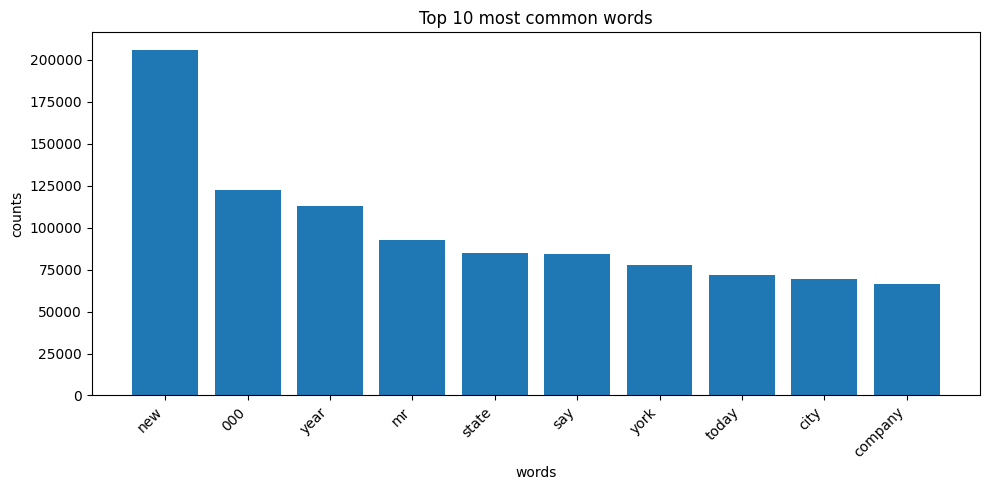

In [6]:
def plot_top_n_words(count_matrix, feature_names, n=10):
    total_counts = np.asarray(count_matrix.sum(axis=0)).ravel()
    top_idx = np.argsort(total_counts)[::-1][:n]
    words = feature_names[top_idx]
    counts = total_counts[top_idx]

    plt.figure(figsize=(10,5))
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.title("Top 10 most common words")
    plt.xlabel("words")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.show()

plot_top_n_words(count_matrix, feature_names, n=10)

In [7]:
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="batch",  # stable for offline corpora
    max_iter=20,
    random_state=42,
    n_jobs=-1
)

lda.fit(count_matrix)
print("LDA trained.")

LDA trained.


In [8]:
def get_topic_words(lda, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic_weights in enumerate(lda.components_):
        top_indices = topic_weights.argsort()[::-1][:n_top_words]
        top_terms = feature_names[top_indices]
        top_weights = topic_weights[top_indices]
        topics.append((topic_idx, list(zip(top_terms, top_weights))))
    return topics

topics = get_topic_words(lda, feature_names, N_TOP_WORDS)

print("\n=== Top keywords per topic ===")
for t_idx, term_pairs in topics:
    human_readable = ", ".join([f"{w} ({int(wt)})" for w, wt in term_pairs])
    print(f"Topic {t_idx:02d}: {human_readable}")

# Save for your report
topic_rows = []
for t_idx, term_pairs in topics:
    for rank, (w, wt) in enumerate(term_pairs, start=1):
        topic_rows.append({"topic": t_idx, "rank": rank, "word": w, "weight": wt})
pd.DataFrame(topic_rows).to_csv("topics_keywords.csv", index=False)

print("\nSaved: topics_keywords.csv")


=== Top keywords per topic ===
Topic 00: united (21739), state (19926), said (14447), official (10898), government (10530), nation (10497), american (10086), today (10066), president (9060), israel (7757), say (7227), military (7214), country (6764), war (6748), israeli (6191), iraq (6018), nuclear (5884), minister (5726), administration (5595), talk (5582)
Topic 01: new (43358), school (30069), york (26474), said (20675), city (18843), state (16482), company (15131), executive (14975), year (12766), president (12044), chief (10515), student (9859), board (9823), public (8796), group (8720), agency (8648), health (8565), yesterday (8210), director (7903), chairman (7781)
Topic 02: music (12105), night (8915), theater (7709), play (7334), new (6015), dance (5485), performance (5227), la (4946), stage (4695), 8220 (4661), 8221 (4637), mr (4295), musical (4228), song (3888), singer (3559), broadway (3519), rock (3502), review (3240), band (3239), audience (3220)
Topic 03: bank (20287), y

In [ ]:
# -----------------------------------------------
# ✅ Topic Coherence Score (C_v) Calculation
# -----------------------------------------------

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np

# Convert topic-word matrix from sklearn into word lists
def get_topics_from_lda(lda_model, feature_names, topn=20):
    topics_words = []
    for comp in lda_model.components_:
        idx = np.argsort(comp)[::-1][:topn]
        topics_words.append([feature_names[i] for i in idx])
    return topics_words

topics_words = get_topics_from_lda(lda, feature_names, topn=N_TOP_WORDS)

# Convert your tokenized text into list-of-tokens format
token_lists = [text.split() for text in df_small[TEXT_COL].tolist()]

# Build dictionary + corpus needed for coherence
id2word = Dictionary(token_lists)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=MAX_FEATURES)
corpus = [id2word.doc2bow(tokens) for tokens in token_lists]

# Compute coherence score (C_v is commonly used for topic modeling eval)
coherence_model = CoherenceModel(
    topics=topics_words, 
    texts=token_lists, 
    dictionary=id2word, 
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()

print(f"✅ Topic Coherence (C_v): {coherence_score:.4f}")

✅ Topic Coherence (C_v): 0.6333


In [11]:
# doc_topic_dist already computed from the same count_matrix you trained on
doc_topic_dist = lda.transform(count_matrix)
dominant_topic = doc_topic_dist.argmax(axis=1)
confidence     = doc_topic_dist.max(axis=1)

# IMPORTANT: match the frame used for vectorization (df_small / df_filt / df)
SOURCE_DF = df_small  # keep whatever you actually used above

# Keep original row ids in case you sampled; handy for merging later
df_out = SOURCE_DF.reset_index(drop=False).rename(columns={"index": "orig_row_id"})
df_out["dominant_topic"] = dominant_topic
df_out["dominant_topic_confidence"] = confidence

df_out.to_csv("documents_with_topics.csv", index=False)
display(df_out.head())
print("Saved: documents_with_topics.csv  (rows:", len(df_out), ")")

,orig_row_id,title_excerpt,tokenized_text,dominant_topic,dominant_topic_confidence
0,7034544,reptd in stable condition after suffering hear...,reptd stable condition suffering heart attack ...,10,0.392312
1,10686959,this week s homes include a california contemp...,week home include california contemporary vine...,19,0.340590
2,769389,reaches amer to join mother who branded him wh...,reach amer join mother branded exiled anatolia...,24,0.304355
3,9715813,suffolk county ny district attorney thomas j...,suffolk county ny district attorney thomas j s...,24,0.483846
4,9461701,edward t norris who became maryland police su...,edward norris became maryland police superinte...,4,0.248329


Saved: documents_with_topics.csv  (rows: 1000000 )


In [12]:
pyLDAvis.enable_notebook()  # enables inline display
ldavis_prepared = lda_vis.prepare(lda, count_matrix, vectorizer)
ldavis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.154206 -0.170185       1        1  5.623915
28    -0.227112  0.104088       2        1  5.237261
9      0.247303  0.004697       3        1  4.979083
1     -0.068931  0.026258       4        1  4.671662
5     -0.134976  0.150832       5        1  4.198523
3     -0.071418  0.142174       6        1  4.078699
0     -0.215546  0.005950       7        1  4.023479
4     -0.135535  0.084467       8        1  3.836237
6      0.072615 -0.088831       9        1  3.741915
29    -0.108311 -0.018054      10        1  3.735059
23    -0.040529 -0.165266      11        1  3.704447
26     0.013293 -0.202900      12        1  3.695272
25     0.145524  0.010783      13        1  3.691502
11    -0.093795 -0.014405      14        1  3.210452
8     -0.079095  0.027711      15        1  3.153954
16     0.163898  0.270511      16        1  3.136492
24     0.007347 -0.016087      17        1  3.040233
18    -0.229529  0.045373      18        1  2.892069
27     0.126819 -0.036099      19        1  2.874027
19    -0.012642 -0.103049      20        1  2.870861
22     0.200079 -0.131362      21        1  2.813073
20    -0.156422  0.036275      22        1  2.788631
10     0.172009  0.137836      23        1  2.660772
2      0.083491 -0.235910      24        1  2.572010
14     0.140310 -0.064317      25        1  2.538199
17    -0.075558  0.035729      26        1  2.504873
21     0.033579 -0.194997      27        1  2.325034
13     0.255715  0.165452      28        1  2.118427
7      0.043631  0.083000      29        1  1.798378
12     0.097994  0.110325      30        1  1.485461, topic_info=           Term           Freq          Total Category  logprob  loglift
1           000  123648.000000  123648.000000  Default  30.0000  30.0000
22761    report   62469.000000   62469.000000  Default  29.0000  29.0000
18462        mr   91627.000000   91627.000000  Default  28.0000  28.0000
6680    company   66020.000000   66020.000000  Default  27.0000  27.0000
18894       new  205492.000000  205492.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
27325      time    3549.384451   58738.283338  Topic30  -4.5990   1.4031
113          10    2473.447173   36640.842183  Topic30  -4.9601   1.5139
5199   business    2256.724999   27746.103716  Topic30  -5.0518   1.7003
29876      york    2054.284382   77060.238396  Topic30  -5.1458   0.5848
22087      rate    1866.158308   19099.270536  Topic30  -5.2419   1.8837

[2332 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
1          5  0.000307   000
1         16  0.999682   000
113        1  0.000218    10
113        2  0.001474    10
113        3  0.044076    10
...      ...       ...   ...
29894     26  0.001331    yr
29894     28  0.001183    yr
29894     29  0.027359    yr
29894     30  0.121265    yr
29973      3  0.997430  zion

[9931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 29, 10, 2, 6, 4, 1, 5, 7, 30, 24, 27, 26, 12, 9, 17, 25, 19, 28, 20, 23, 21, 11, 3, 15, 18, 22, 14, 8, 13])

In [13]:
html_path = f"ldavis_prepared_{N_TOPICS}.html"
pyLDAvis.save_html(ldavis_prepared, html_path)
print("Saved:", html_path)

Saved: ldavis_prepared_30.html


# Coherence Reporting

In [7]:
import pickle
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np

def get_topics_from_lda(lda_model, feature_names, topn=20):
    topics_words = []
    for comp in lda_model.components_:
        idx = np.argsort(comp)[::-1][:topn]
        topics_words.append([feature_names[i] for i in idx])
    return topics_words


vectorizer = None
with open(f'count_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

feature_names = vectorizer.get_feature_names_out()
N_TOP_WORDS = 20


# Convert your tokenized text into list-of-tokens format
token_lists = [text.split() for text in df[TEXT_COL].tolist()]

# Build dictionary + corpus needed for coherence
id2word = Dictionary(token_lists)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=MAX_FEATURES)
corpus = [id2word.doc2bow(tokens) for tokens in token_lists]


for modelId in range(5, 30, 5):
    lda = None
    with open(f'lda_model-n-topics-{modelId}.pk', 'rb') as f:
        lda = pickle.load(f)
    
    print(f'checking {modelId}')

    # Convert topic-word matrix from sklearn into word lists
    topics_words = get_topics_from_lda(lda, feature_names, topn=N_TOP_WORDS)
    
    # Compute coherence score (C_v is commonly used for topic modeling eval)
    coherence_model = CoherenceModel(
        topics=topics_words, 
        texts=token_lists, 
        dictionary=id2word, 
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()

    print(f"✅ Topic Coherence for model {modelId} (C_v): {coherence_score:.4f}")

checking 5
✅ Topic Coherence for model 5 (C_v): 0.6128
checking 10
✅ Topic Coherence for model 10 (C_v): 0.6172
checking 15
✅ Topic Coherence for model 15 (C_v): 0.6215
checking 20
✅ Topic Coherence for model 20 (C_v): 0.6146
checking 25
✅ Topic Coherence for model 25 (C_v): 0.5819


In [8]:
lda = None
with open(f'lda_model-n-topics-15.pk', 'rb') as f:
    lda = pickle.load(f)



In [9]:
def get_topic_words(lda, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic_weights in enumerate(lda.components_):
        top_indices = topic_weights.argsort()[::-1][:n_top_words]
        top_terms = feature_names[top_indices]
        top_weights = topic_weights[top_indices]
        topics.append((topic_idx, list(zip(top_terms, top_weights))))
    return topics

topics = get_topic_words(lda, feature_names, N_TOP_WORDS)

print("\n=== Top keywords per topic ===")
for t_idx, term_pairs in topics:
    human_readable = ", ".join([f"{w} ({int(wt)})" for w, wt in term_pairs])
    print(f"Topic {t_idx:02d}: {human_readable}")

# Save for your report
topic_rows = []
for t_idx, term_pairs in topics:
    for rank, (w, wt) in enumerate(term_pairs, start=1):
        topic_rows.append({"topic": t_idx, "rank": rank, "word": w, "weight": wt})
pd.DataFrame(topic_rows).to_csv("topics_keywords-15.csv", index=False)

print("\nSaved: topics_keywords-15.csv")


=== Top keywords per topic ===
Topic 00: report (740391), company (654590), 000 (631821), year (356073), million (340904), share (338516), percent (330136), inc (329726), qtr (314660), earnings (313985), billion (260331), 30 (257182), 31 (241838), bank (237569), net (236592), said (192677), rate (180708), lead (156467), sale (153655), corp (134987)
Topic 01: new (327934), art (294629), music (231039), show (189057), york (173665), museum (155754), review (128156), night (126841), street (123090), work (121117), dance (116168), hall (114043), sunday (110236), computer (109583), performance (108932), photo (108193), play (106351), concert (96070), festival (93475), opera (93319)
Topic 02: market (327426), price (322809), stock (219278), week (168367), new (140171), business (122682), day (102453), exchange (101404), sale (93173), trade (92281), oil (89043), yesterday (89038), trading (88596), rise (85436), last (79801), bond (78703), point (78238), future (70136), food (65780), level (6

In [11]:
from scipy import sparse
from scipy.sparse import csr_matrix, save_npz, load_npz
import numpy as np


count_matrix = load_npz('dtm.npz')


In [12]:
pyLDAvis.enable_notebook()  # enables inline display
ldavis_prepared = lda_vis.prepare(lda, count_matrix, vectorizer)
ldavis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.042471 -0.040413       1        1  15.401584
7      0.181351  0.112987       2        1   9.628276
10     0.161383  0.124451       3        1   8.028940
9     -0.060174 -0.197329       4        1   7.398943
4      0.048283 -0.050370       5        1   7.022977
0      0.098110 -0.065477       6        1   6.933038
6     -0.290471  0.013428       7        1   6.850025
8      0.089924  0.072876       8        1   6.493343
11     0.167780  0.062044       9        1   6.071573
1     -0.119550 -0.118465      10        1   5.424486
2      0.124410 -0.109569      11        1   5.230290
12     0.103238  0.068615      12        1   4.772462
13    -0.142766  0.054097      13        1   4.655413
3     -0.118629 -0.203704      14        1   4.291556
5     -0.285360  0.276829      15        1   1.797093, topic_info=              Term          Freq         Total Category  logprob  loglift
811177          mr  8.892910e+05  8.892910e+05  Default  30.0000  30.0000
1              000  1.027605e+06  1.027605e+06  Default  29.0000  29.0000
996024      report  6.850640e+05  6.850640e+05  Default  28.0000  28.0000
1051848     school  4.385060e+05  4.385060e+05  Default  27.0000  27.0000
293374     company  8.100380e+05  8.100380e+05  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
1241889        van  2.004161e+04  4.958902e+04  Topic15  -5.5681   3.1130
76356           ad  1.972808e+04  6.543864e+04  Topic15  -5.5838   2.8199
423726   executive  2.613298e+04  2.263757e+05  Topic15  -5.3027   1.8600
361509    director  2.491099e+04  1.955085e+05  Topic15  -5.3506   1.9587
823036       named  1.656160e+04  1.413293e+05  Topic15  -5.7588   1.8750

[1287 rows x 6 columns], token_table=         Topic      Freq    Term
term                            
1            1  0.000122     000
1            2  0.000587     000
1            3  0.000107     000
1            4  0.024556     000
1            5  0.396395     000
...        ...       ...     ...
1323857      2  0.999837  zoning
1323905      1  0.002704     zoo
1323905      4  0.000118     zoo
1323905      5  0.000470     zoo
1323905     15  0.996667     zoo

[7270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 8, 11, 10, 5, 1, 7, 9, 12, 2, 3, 13, 14, 4, 6])

Topic Coherence for model 30 (C_v): 0.633

# Reporting

In [1]:
import pandas as pd
import numpy as np


In [13]:
df = pd.read_csv("topics_keywords-15.csv")
df.head()

,topic,rank,word,weight
0,0,1,report,740391.134795
1,0,2,company,654590.285195
2,0,3,000,631821.936735
3,0,4,year,356073.711745
4,0,5,million,340904.816362


In [20]:
df.groupby("topic")[['word', 'weight']].agg(word_list=('word', lambda x: ", ".join(x.tolist()[0:3])), weight=('weight', 'sum')).reset_index().sort_values(by='weight')

,topic,word_list,weight
26,26,"day, year, park",89609.826487
20,20,"troop, force, protest",92612.404678
2,2,"music, night, theater",104428.791153
14,14,"street, hall, new",108093.441940
21,21,"art, museum, new",115496.899846
12,12,"article, news, correction",119741.601352
7,7,"letter, ed, white",123859.656638
22,22,"new, film, book",128669.342989
23,23,"woman, year, life",128936.056127
17,17,"air, ship, army",129699.161824


In [32]:
chart_data = df.groupby("topic")["word"].apply(lambda x: ", ".join(x.tolist()[0:5])).reset_index()
chart_data['topic'] += 1

chart_data = chart_data.rename(columns={'word':'Top 5 Words'})

chart_data

,topic,Top 5 Words
0,1,"report, company, 000, year, million"
1,2,"new, art, music, show, york"
2,3,"market, price, stock, week, new"
3,4,"title, club, win, trump, round"
4,5,"000, new, city, million, building"
5,6,"tv, san, nj, theater, ed"
6,7,"mr, death, son, john, daughter"
7,8,"state, new, plan, say, bill"
8,9,"court, case, charge, police, said"
9,10,"game, team, first, league, today"


In [23]:
#display table
chart_data.to_frame(name="Top 5 Words per Topic")


AttributeError: 'DataFrame' object has no attribute 'to_frame'

## Get most popular topics

In [21]:
df = pd.read_csv("documents_with_topics.csv")
df.head()

,title_excerpt,dominant_topic,dominant_topic_confidence
0,days of wine and roses filming discussed day...,1,0.909986
1,in venezuela women are confronted with a cult...,1,0.746663
2,this town offers a catholic variety of night c...,1,0.880132
3,zetland holds brit obligations to india preven...,2,0.791691
4,less than two days before the n b a draft th...,6,0.436462


In [22]:
df.shape

(100000, 3)

In [27]:
df.groupby("dominant_topic")['dominant_topic'].count()

dominant_topic
0    14149
1    16203
2    11396
3     6129
4     9279
5     8423
6    10976
7    11678
8     4759
9     7008
Name: dominant_topic, dtype: int64